Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Other Imports
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

## **Do train/ validate/ test split with the Tanzania Waterpumps data**


In [5]:
# The Tanzania Waterpumps data is already split into train/test so I will split
# train data into train/val
Train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=24)

In [6]:
print('Train shape:',train.shape,'Test shape:',test.shape)
print('Train and validation:',Train.shape[0]+val.shape[0])

Train shape: (59400, 41) Test shape: (14358, 40)
Train and validation: 59400


## **Begin with baselines for classification**

In [7]:
tclass = Train['status_group'].value_counts(normalize=True)
print(f'The target majority class is "functional" at {tclass[0]:.2f}')
tclass

The target majority class is "functional" at 0.54


functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

## **Select features:**


In [8]:
# Function from lecture to wrangle train, val, and test sets the same
def wrangle(X):
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Creating nans to be imputed later
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    return X


Train = wrangle(Train)
val = wrangle(val)
test = wrangle(test)

In [9]:
# Target is status_group 
target = 'status_group'

# Dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 75
categorical_features = cardinality[cardinality <= 75].index.tolist()

# Combine lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [10]:
# Arrange data into X features matrix and y target vector

x_train = Train[features]
x_val   = val[features]
x_test  = test[features]

y_train = Train[target]
y_val   = val[target]

In [11]:
x_train

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,region,public_meeting,recorded_by,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
29847,0.0,0,33.849558,-9.554973,0,12,3,0,0,Lake Nyasa,Mbeya,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe
1528,200.0,1582,35.210923,-9.215126,0,11,4,150,1999,Rufiji,Iringa,True,GeoData Consultants Ltd,VWC,True,other,other,other,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8416,0.0,0,33.134510,-9.277045,0,12,2,0,0,Lake Nyasa,Mbeya,False,GeoData Consultants Ltd,VWC,False,nira/tanira,nira/tanira,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
13551,0.0,1315,29.899603,-4.386133,0,16,2,950,2009,Lake Tanganyika,Kigoma,True,GeoData Consultants Ltd,Water authority,False,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
57334,0.0,1140,33.170558,-2.130748,0,19,1,400,2004,Lake Victoria,Mwanza,True,GeoData Consultants Ltd,NaN,True,other,other,other,vwc,user-group,never pay,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54505,0.0,0,32.867825,-4.434182,0,14,1,0,0,Lake Tanganyika,Tabora,True,GeoData Consultants Ltd,VWC,True,afridev,afridev,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
18808,0.0,0,NaN,NaN,0,19,2,0,0,Lake Victoria,Mwanza,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,lake,river/lake,surface,communal standpipe,communal standpipe
21621,200.0,1244,30.133772,-4.539337,0,16,2,740,1996,Lake Tanganyika,Kigoma,True,GeoData Consultants Ltd,Water authority,True,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
23849,0.0,0,32.076740,-3.554029,0,17,5,0,0,Lake Tanganyika,Shinyanga,True,GeoData Consultants Ltd,WUG,True,other,other,other,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other


### Use a scikit-learn pipeline to:
1. Encode categoricals
2. Impute missing values
3. Fit a decision tree classifier

In [12]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'), 
    DecisionTreeClassifier(min_samples_leaf=10,random_state=26))

# Fit on train
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     's...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                               

## **Get your validation accuracy score**

In [13]:
# Score
print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

Train Accuracy 0.8392045454545455
Validation Accuracy 0.7687710437710438


## **Get and plot your feature importances**

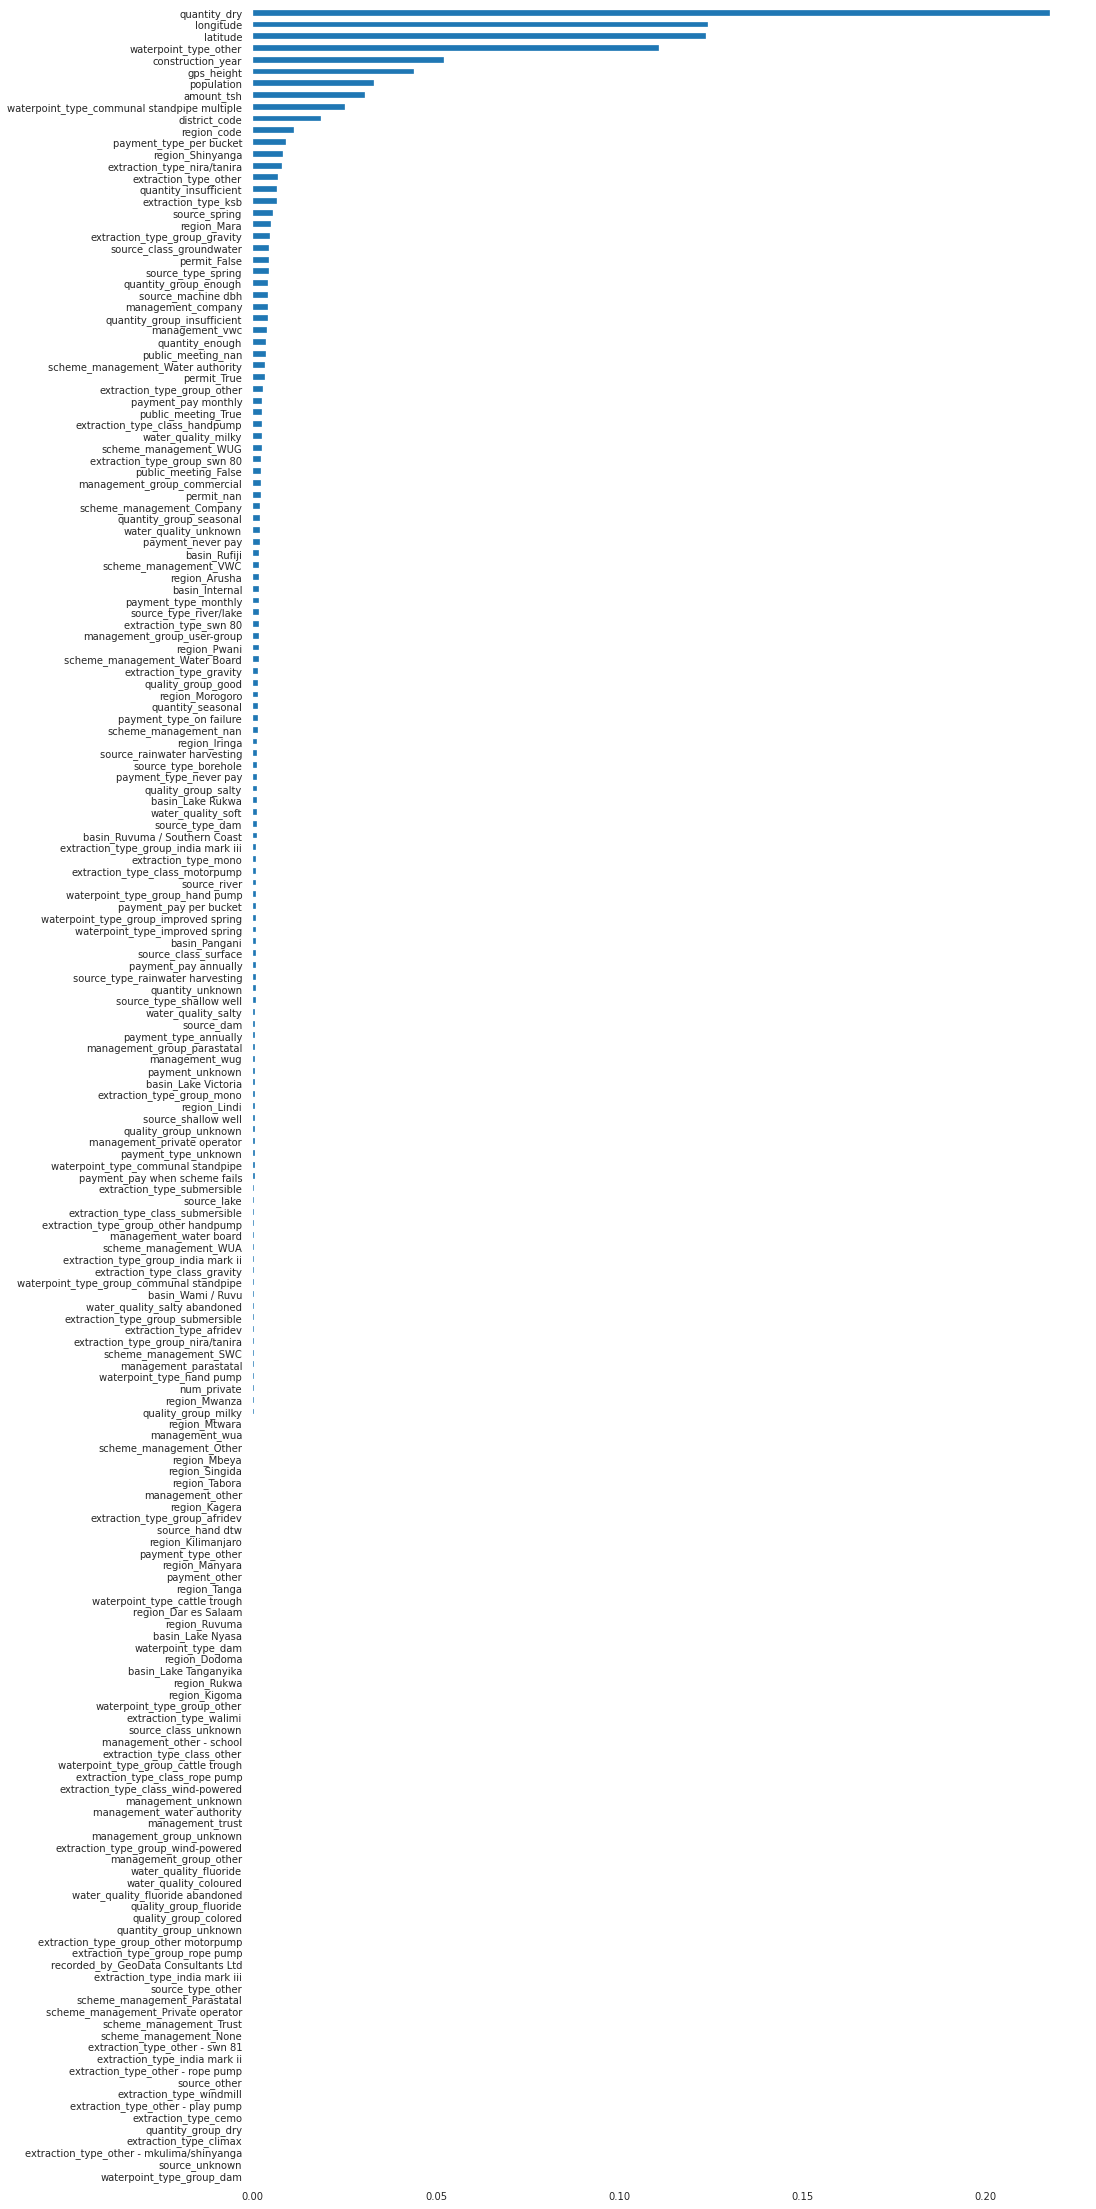

In [14]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(x_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(15,40))
importances.sort_values().plot.barh();

## **Predict and submit test predictions**

In [15]:
# Predict on test data
t_pred = pipeline.predict(x_test)

In [16]:
# Create Kaggle submission
submission = test[['id']].copy()
submission['status_group'] = t_pred
submission.to_csv('Meghan_Felker_TWPP.csv', index=False)

In [17]:
pd.read_csv('Meghan_Felker_TWPP.csv')

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,non functional
14356,33492,functional
